# Performance and error scaling with discretization

Rudimentary performance and error analysis is performed for different `action_step` discretization sizes, with and without exactly computing moments, for a single action.

Performance is measured by how quickly the first three moments can be computed with the damage distributions (via convolutions) and with convolutions and moment generating functions (MGFs).

Error analysis is measured by comparing the percent difference in the first three moments computed via discretized convolved damage distributions (approximate) and MGFs (exact).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../ffxiv_stats")
from moments import ActionMoments

In [2]:
index = [
    "action_name",
    "base_action",
    "n",
    "p_n",
    "p_c",
    "p_d",
    "p_cd",
    "buffs",
    "l_c",
    "main_stat_add",
    "potency",
    "damage_type",
    "d2",
    "is_dot",
]

data = [
    "Hissatsu: Shinten-1000638_1001221_1001298_1001",
    "Hissatsu: Shinten",
    25,
    0.20748,
    0.28652,
    0.21252,
    0.29348,
    1.428571,
    1630.0,
    262,
    250,
    "direct",
    8636.0,
    0,
]



hit = pd.Series(data, index=index)
hit

action_name      Hissatsu: Shinten-1000638_1001221_1001298_1001
base_action                                   Hissatsu: Shinten
n                                                            25
p_n                                                     0.20748
p_c                                                     0.28652
p_d                                                     0.21252
p_cd                                                    0.29348
buffs                                                  1.428571
l_c                                                      1630.0
main_stat_add                                               262
potency                                                     250
damage_type                                              direct
d2                                                       8636.0
is_dot                                                        0
dtype: object

## Performance analysis

Use action delta steps of 1000, 50, and 10, each with and without computing the MGFs.

For large `action_delta`, the total compute time is dominated by the time to compute MGFs, which remains constant.

Speedups around 3-5x are present even for modest `action_delta` values like 10-50.

In [3]:
%%timeit

ActionMoments(hit, 1, action_delta=1000, compute_mgf=False)

675 µs ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [4]:
%%timeit

ActionMoments(hit, 1, action_delta=1000, compute_mgf=True)

5.59 ms ± 68.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit

ActionMoments(hit, 1, action_delta=50, compute_mgf=False)

1.38 ms ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
%%timeit

ActionMoments(hit, 1, action_delta=50, compute_mgf=True)

6.09 ms ± 70.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit

ActionMoments(hit, 1, action_delta=10, compute_mgf=False)

4.2 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit

ActionMoments(hit, 1, action_delta=10, compute_mgf=True)

7.91 ms ± 87.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Error comparison

Compare percent error in the first three moments with different `action_delta` steps.

The approximate moments are given hats, treating them as sample moments, e.g., $\hat{\mu}$.

The mean and standard deviation are within 1% of the true values even for very large `action_delta` values.

The skewness has very large errors because (i) it is a ratio of the mean and variance exponentiated, so small errors are likely magnified and (ii) the values are relatively small and close to 0, so small changes can lead to large percent differences. However, the skewness is almost always 0 for rotations and is the least important moment to compute with high accuracy.

In [9]:
true_values = ActionMoments(hit, 1, action_delta=1, compute_mgf=True)

true_mean = true_values.mean
true_std = true_values.standard_deviation
true_skew = true_values.skewness

app_mean = []
app_std = []
app_skew = []

action_step = [1, 10, 25, 50, 100, 250, 500, 1000]
for step in action_step:
    new_values = ActionMoments(hit, 1, action_delta=step, compute_mgf=False)
    app_mean.append(new_values.mean)
    app_std.append(new_values.standard_deviation)
    app_skew.append(new_values.skewness)

true_skew, app_skew

(0.0017473118971213814,
 [0.0017473119164050537,
  0.002099211507984694,
  0.0026053598613803297,
  0.005273037566481453,
  0.0010062257682585951,
  -0.0009811253152555155,
  -0.0019429553073385675,
  -0.026710222772284853])

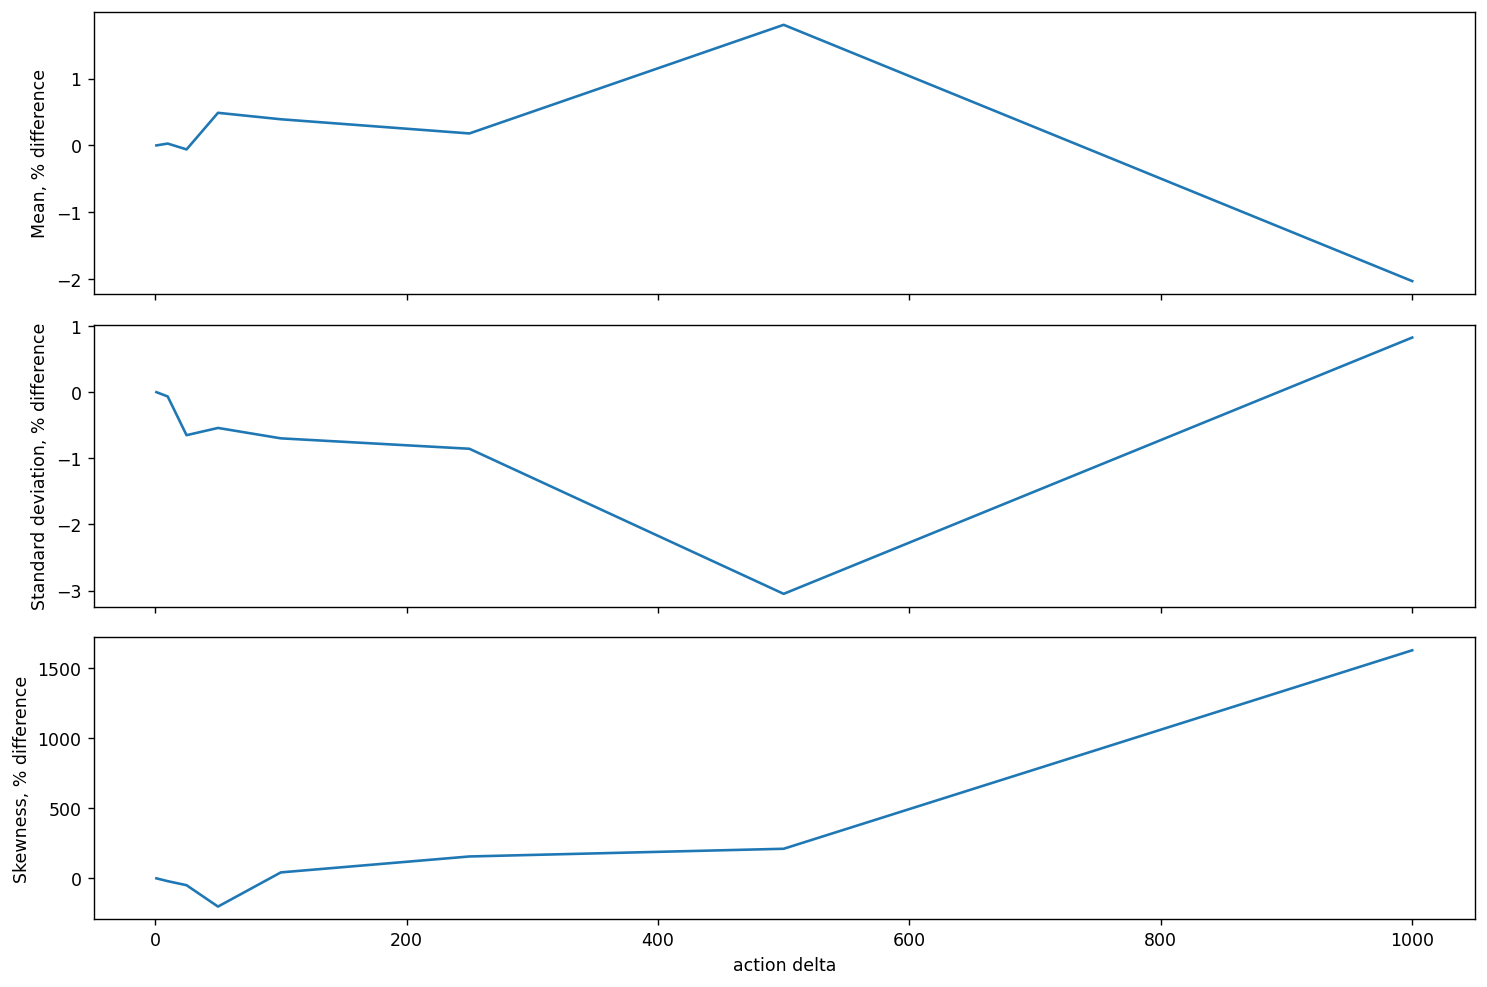

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), dpi=125, sharex=True)

ax[0].plot(action_step, 100 * (true_mean - np.array(app_mean)) / true_mean)
ax[1].plot(action_step, 100 * (true_std - np.array(app_std)) / true_std)
ax[2].plot(action_step, 100 * (true_skew - np.array(app_skew)) / true_skew)

ax[0].set_ylabel(r"Mean, % difference")
ax[1].set_ylabel(r"Standard deviation, % difference")
ax[2].set_ylabel(r"Skewness, % difference")
ax[2].set_xlabel("action delta")
plt.tight_layout()